In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize, Minuit
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from multiprocessing import Pool

In [2]:
# Fixed the bins, colors, mass arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_mid = bins[:-1]+bins_w/2
bins_dense = np.linspace(bins_min, bins_max, 1000)

mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
top_mass_chi2 = np.linspace(166, 180, 1000)
sudo_bins = np.arange(166, 180, 0.2)
sudo_bins_dense = np.linspace(166, 180, 1000)

loglikeli_cut = -78
marginal_prob_cut = 0.23
states = [0, 1, 2]
sudo_event = 10000

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Std of Gaussian', 'Fraction of Gaussian']


In [3]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    bins_min < reco_m_top < bins_max
    additional cuts (same as CMS)
    """
    reco_cuts = np.logical_and(dic['reconstructed_top_mass'] > bins_min, dic['reconstructed_top_mass'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], state, reco_cuts
    

In [4]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}
reco_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}
reco_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}

for m in mass:
    h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_{}_gev_with_spanet_pdnn_KLFitter.h5'.format(m), "r")
    reco_klf_dic[m], state_klf_dic[m], cut_klf_dic[m], likeli_klf_dic[m] = get_reco_top_mass(h5py_file, 'klfitter')
    reco_spanet_dic[m], state_spanet_dic[m], cut_spanet_dic[m], likeli_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_perfect_dic[m], state_perfect_dic[m], cut_perfect_dic[m] = get_reco_top_mass(h5py_file, 'target')
    

/tmp/ipykernel_21860/2974517710.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


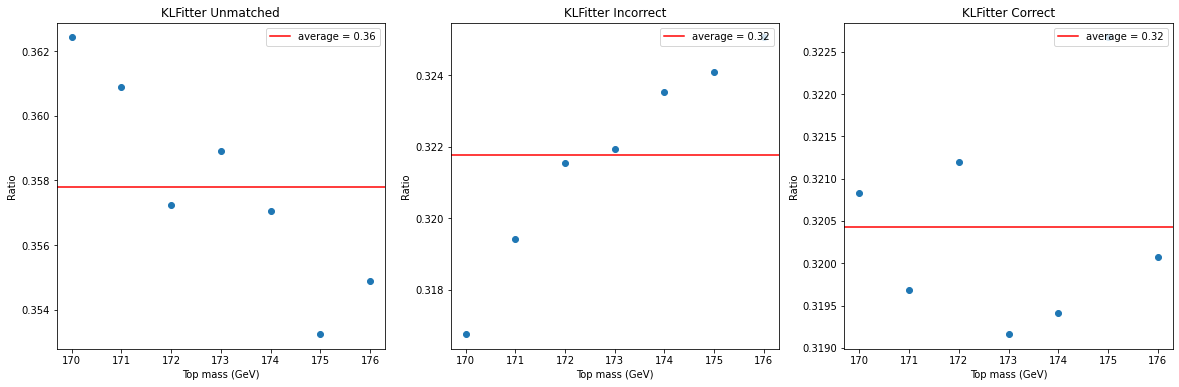

In [5]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in states:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])])
        ratio_klf_dic[state_i].append(ratio)
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}

plt.figure(figsize=(20, 6))
for state_i in states:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_klf_dic[state_i])
    plt.axhline(ratio_klf[state_i], c='r', label=f'average = {ratio_klf[state_i]:.2f}')
    plt.title('KLFitter ' + state_labels[state_i])
    plt.xlabel('Top mass (GeV)')
    plt.ylabel('Ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/KLFitter ratio.png')
plt.show()


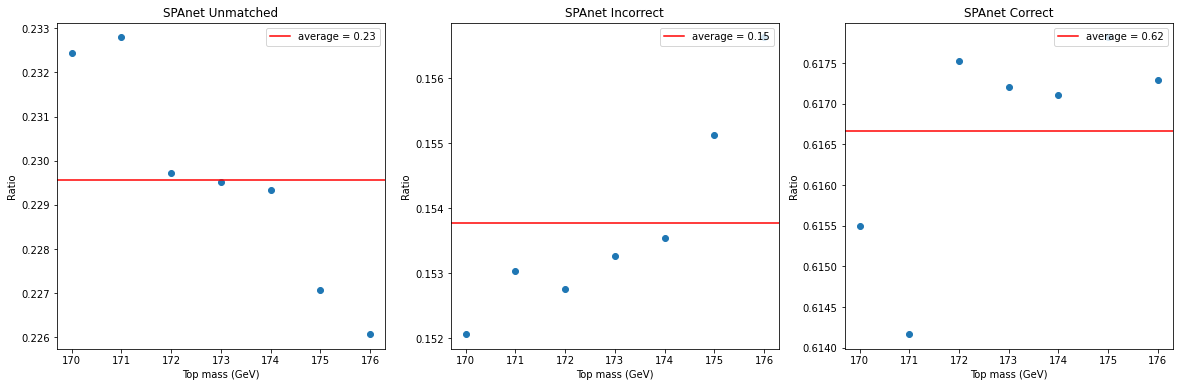

In [6]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in states:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])])
        ratio_spanet_dic[state_i].append(ratio)
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}

plt.figure(figsize=(20, 6))
for state_i in states:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_spanet_dic[state_i])
    plt.axhline(ratio_spanet[state_i], c='r', label=f'average = {ratio_spanet[state_i]:.2f}')
    plt.title('SPAnet ' + state_labels[state_i])
    plt.xlabel('Top mass (GeV)')
    plt.ylabel('Ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/SPAnet ratio.png')
plt.show()


In [7]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, x[0]-bins_w/2, x[-1]+bins_w/2, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Linear
def linear(x, a, b):
    return a*(x-173)+b

def fcn(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

def chi2_pdf(observed, pdf): #observed is the observation, pdf is the normalized height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

In [18]:
pdf_klf_top_dic = {(0, 0): np.array([  2.13388883, 164.85909233]),
             (0, 1): np.array([ 0.46825294, 28.94252485]),
             (0, 2): np.array([ -3.00466015, 160.37815841]),
             (0, 3): np.array([ 0.84009439, 24.83310531]),
             (0, 4): np.array([0.0467599, 0.1694456]),
             (1, 0): np.array([  0.18765847, 146.62501881]),
             (1, 1): np.array([-0.15067472, 22.26555384]),
             (1, 2): np.array([  1.71032697, 164.30279908]),
             (1, 3): np.array([-0.5067314 , 19.11959715]),
             (1, 4): np.array([0.00261698, 0.12249245]),
             (2, 0): np.array([  0.99302268, 174.45340577]),
             (2, 1): np.array([0.02718499, 8.77839373]),
             (2, 2): np.array([  0.87288652, 166.69135122]),
             (2, 3): np.array([ 0.09737269, 17.45571325]),
             (2, 4): np.array([-1.40619822e-04,  7.13073405e-01])}
fit_limit = [(0.5, 1.5), (0.5, 1.5), (0.5, 1.5), (0.5, 1.5), (0.5, 1.5)]

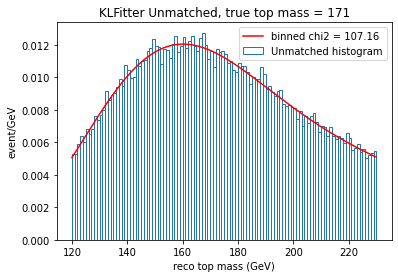

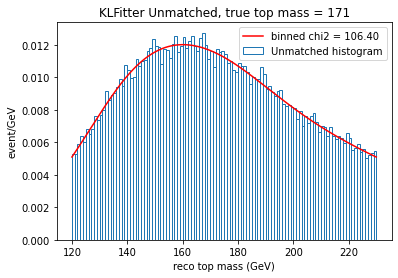

/tmp/ipykernel_21860/1497013287.py:22: RuntimeWarning: invalid value encountered in log
  return -2*np.sum(hist*np.log(langau_norm(bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event
/tmp/ipykernel_21860/1497013287.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, x[0]-bins_w/2, x[-1]+bins_w/2, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]


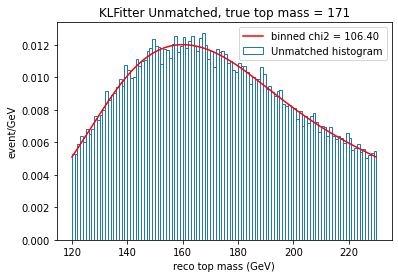

In [38]:
smallest_fcn = np.inf
for i in range(10):
    m, state_i = 171, 0
    fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
    hist, _ = np.histogram(fit_target, bins=bins, density=True)
    tot_event = len(fit_target)
    tol = 0.1
    while True:
        try:
            limits = [(100, 250), (5, 50), (100, 250), (10, 50), (0.1, 0.9)]
            start = [np.random.uniform(limits[i][0], limits[i][1]) for i in range(5)]
            minuit = Minuit(fcn, *start)
            minuit.limits = limits
            minuit.tol = tol
            minuit.migrad()
            minuit.minos()
        except: tol *= 2
        else: break
    
    if minuit.fval < smallest_fcn:
        smallest_fcn = minuit.fval
        popt, errors = list(minuit.values), list(minuit.errors)
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('KLFitter {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
        plt.show()

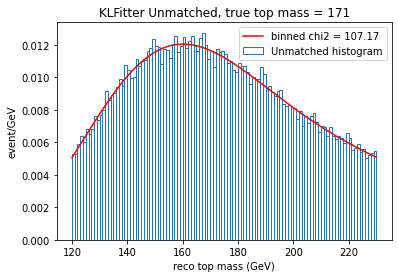

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.523e+05                  │             Nfcn = 3680              │
│ EDM = 0.000335 (Goal: 0.0008)    │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lan_loc   │   162.9   │    1.2    │    -3.8    │    1.1     │ 80.2957 │ 240.887 │       │
│ 1 │ lan_scale │   29.9    │    1.0    │    -1.0    │    1.3     │ 14.003  │ 42.009  │       │
│ 2 │ gau_loc   │    155    │     4     │     -4     │     11     │ 83.1937 │ 249.581 │       │
│ 3 │ gau_scale │   26.8    │    2.1    │    -7.7    │    4.4     │ 11.5765 │ 34.7294 │       │
│ 4 │ f         │   0.108   │   0.014   │   -0.070   │   0.006    │0.0379629│0.113889 │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │        lan_loc        │       lan_scale       │        gau_loc        │       gau_scale       │           f           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -3.8    │    1.1    │   -1.0    │    1.3    │    -4     │    11     │    -8     │     4     │  -0.070   │   0.006   │
│  Valid   │   True    │   True    │   False   │   True    │   False   │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   True    │   True    │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │   lan_loc lan_scale   gau_loc gau_scale         f │
├───────────┼───────────────────────────────────────────────────┤
│   lan_loc │      1.53     0.295     -3.35    0.0663    0.0143 │
│ lan_scale │     0.295     0.913       1.7     -1.51   0.00465 │
│   gau_loc │     -3.35       1.7      15.1      -4.1    -0.021 │
│ gau_scale │    0.0663     -1.51      -4.1      4.49   0.00709 │
│         f │    0.0143   0.00465    -0.021   0.00709   0.00024 │
└───────────┴───────────────────────────────────────────────────┘

In [22]:
m, state_i = 171, 0
fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
hist, _ = np.histogram(fit_target, bins=bins, density=True)
tot_event = len(fit_target)
tol = 0.1
while True:
    try:
        start = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        minuit = Minuit(fcn, *start)
        minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
        minuit.tol = tol
        minuit.migrad()
        minuit.minos()
    except: tol *= 2
    else: break
popt, errors = list(minuit.values), list(minuit.errors)
plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
plt.title('KLFitter {}, true top mass = {}'.format(state_labels[state_i], m))
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')
plt.show()
minuit

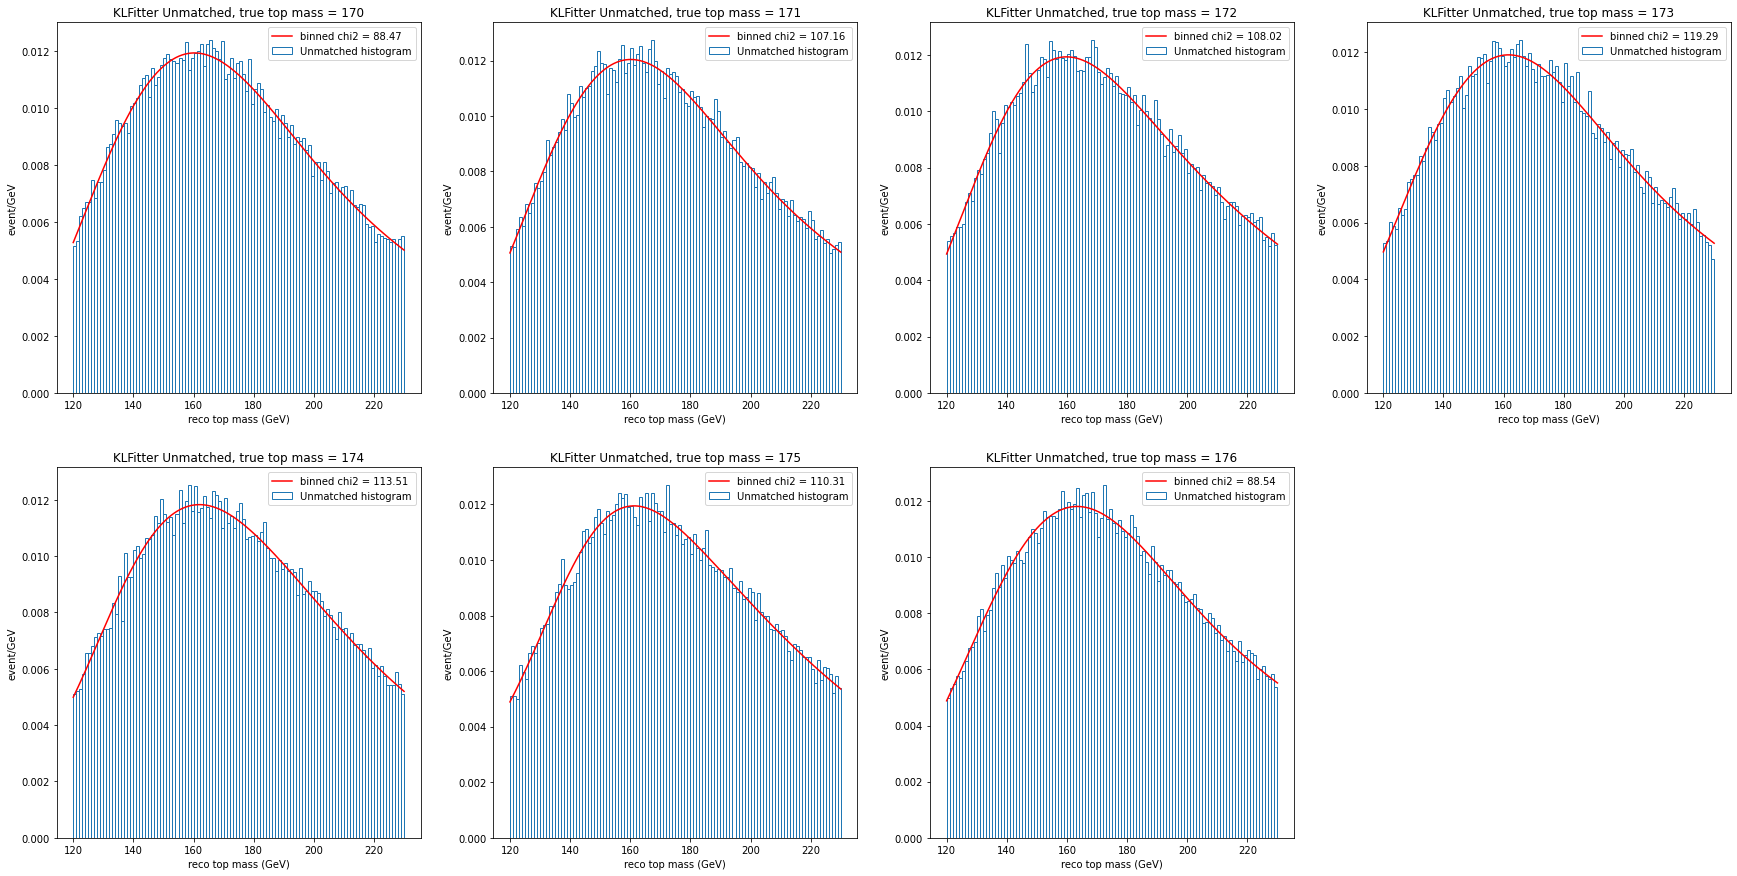

/tmp/ipykernel_21860/1497013287.py:22: RuntimeWarning: invalid value encountered in log
  return -2*np.sum(hist*np.log(langau_norm(bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event
/tmp/ipykernel_21860/1497013287.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, x[0]-bins_w/2, x[-1]+bins_w/2, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]


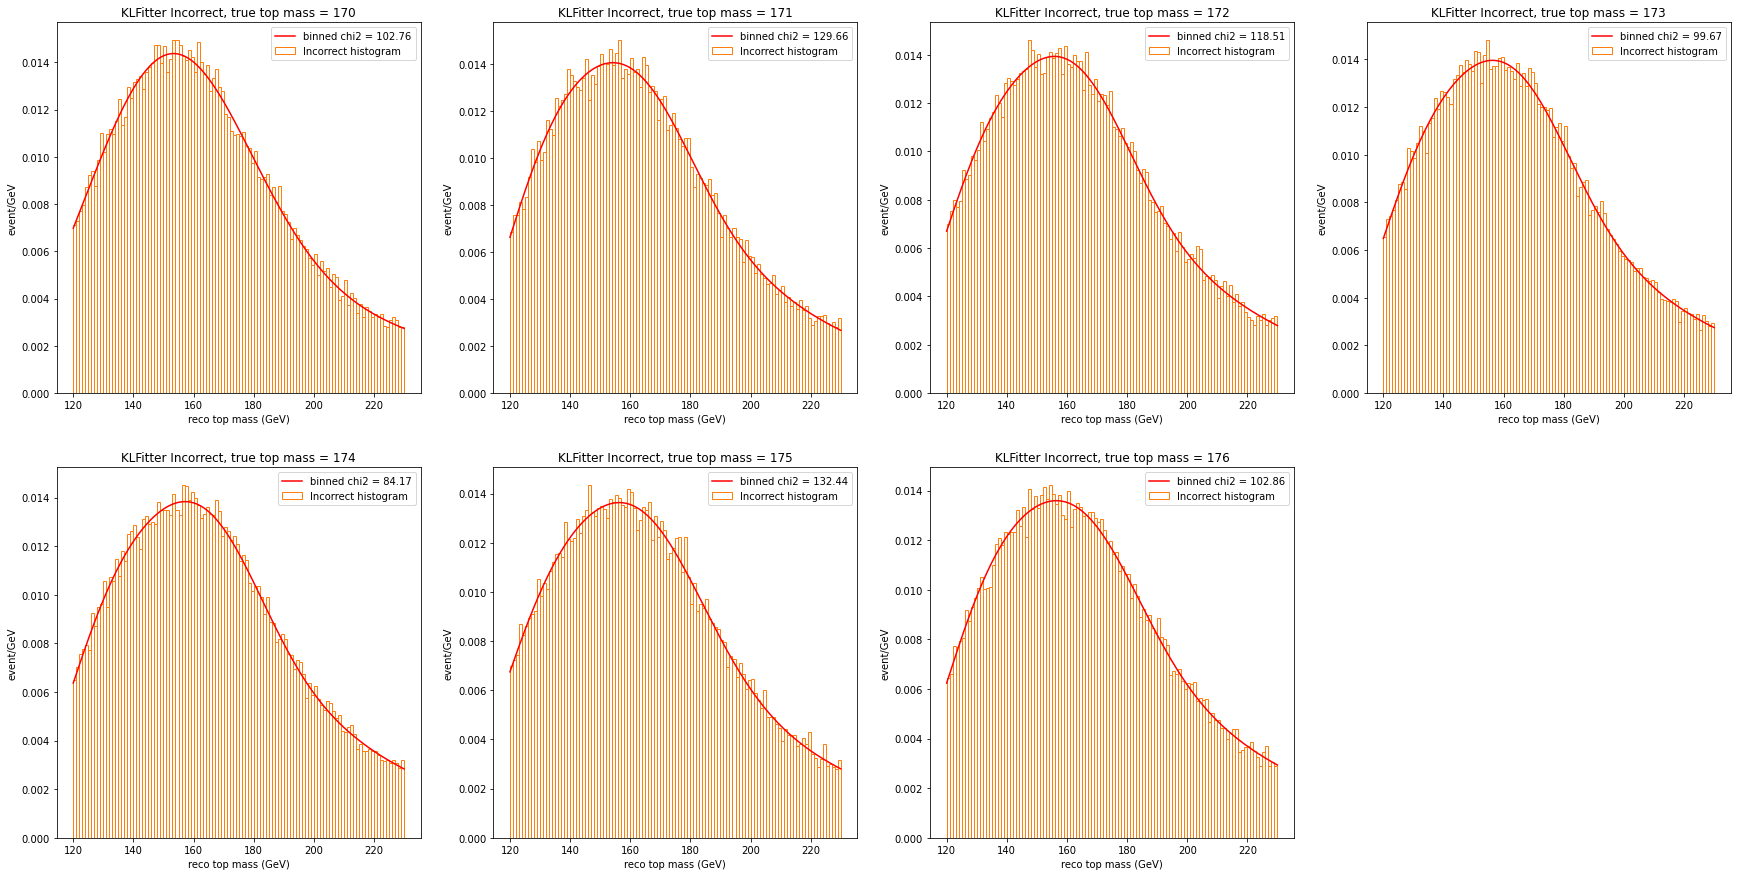

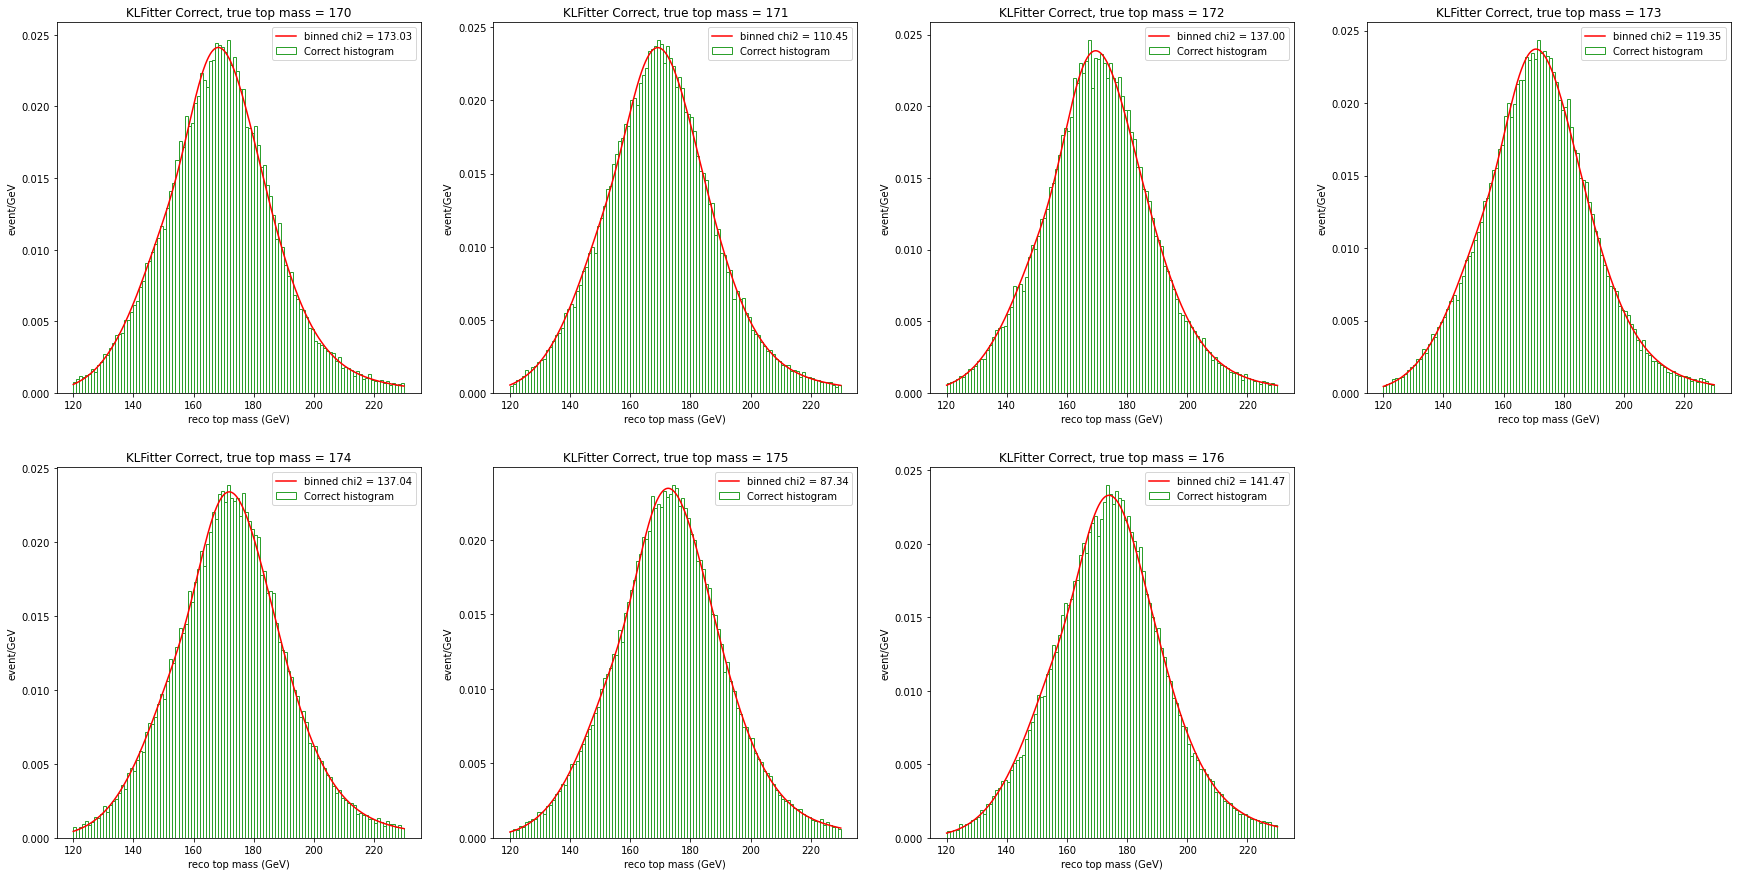

In [26]:
# Fit every class of klfitter
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    popt_klf_arr = []
    perr_klf_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        tol = 0.1
        while True:
            try:
                start = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
                minuit = Minuit(fcn, *start)
                minuit.limits = [(100, 250), (5, 50), (100, 250), (10, 50), (0.1, 0.9)]
                minuit.tol = tol
                minuit.migrad()
                minuit.minos()
            except: tol *= 2
            else: break
        popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('KLFitter {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/KLFitter_pdf_fit/KLFitter top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

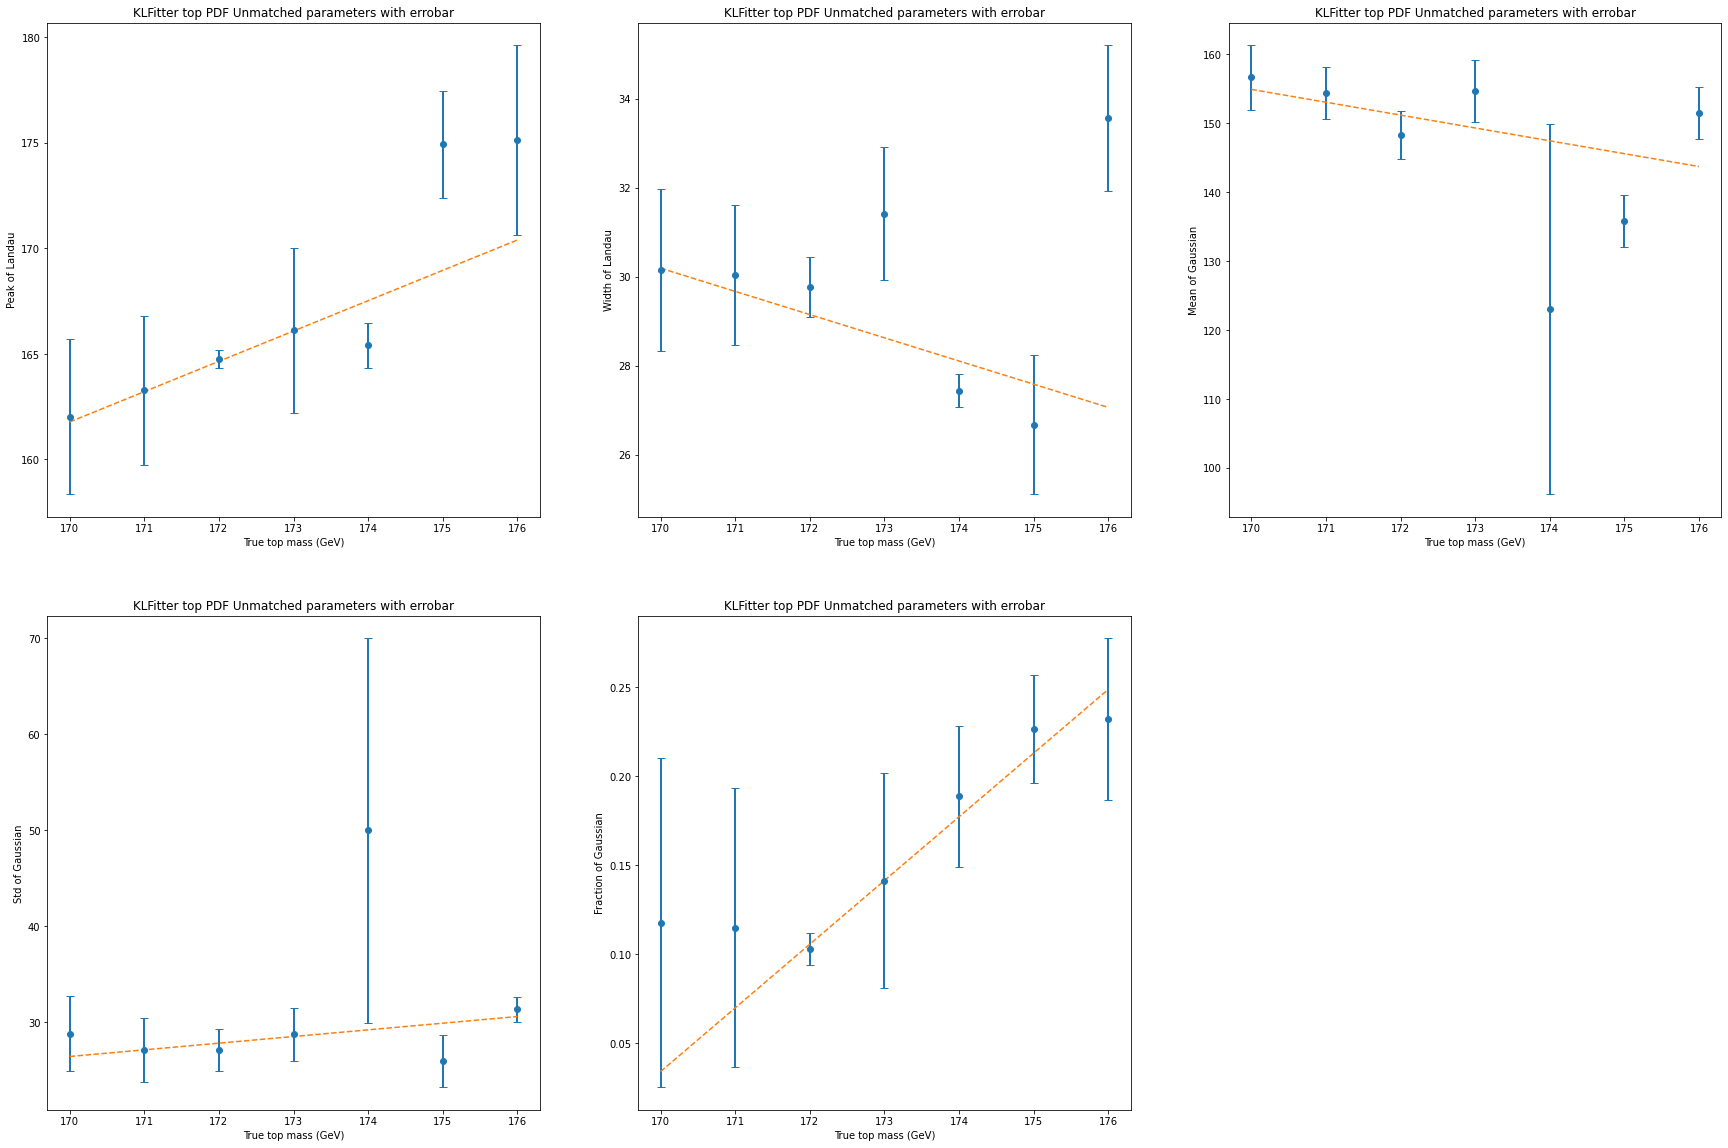

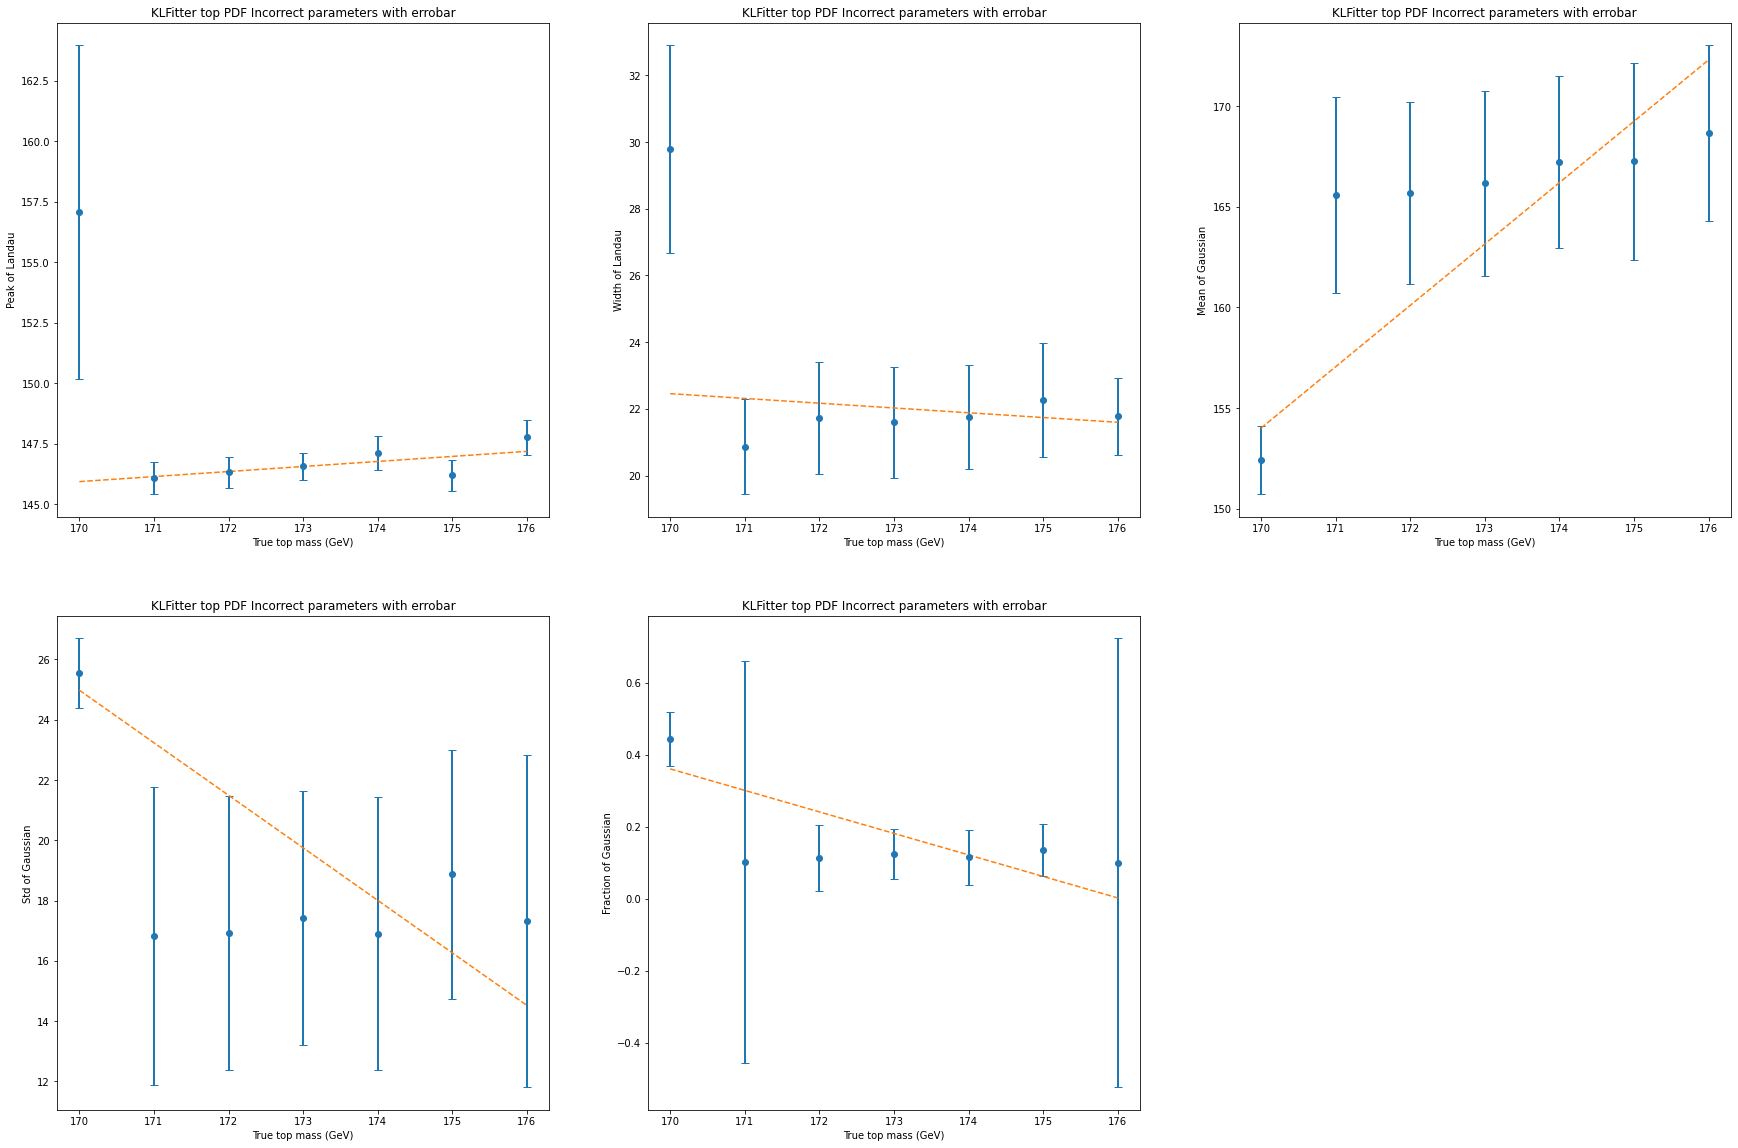

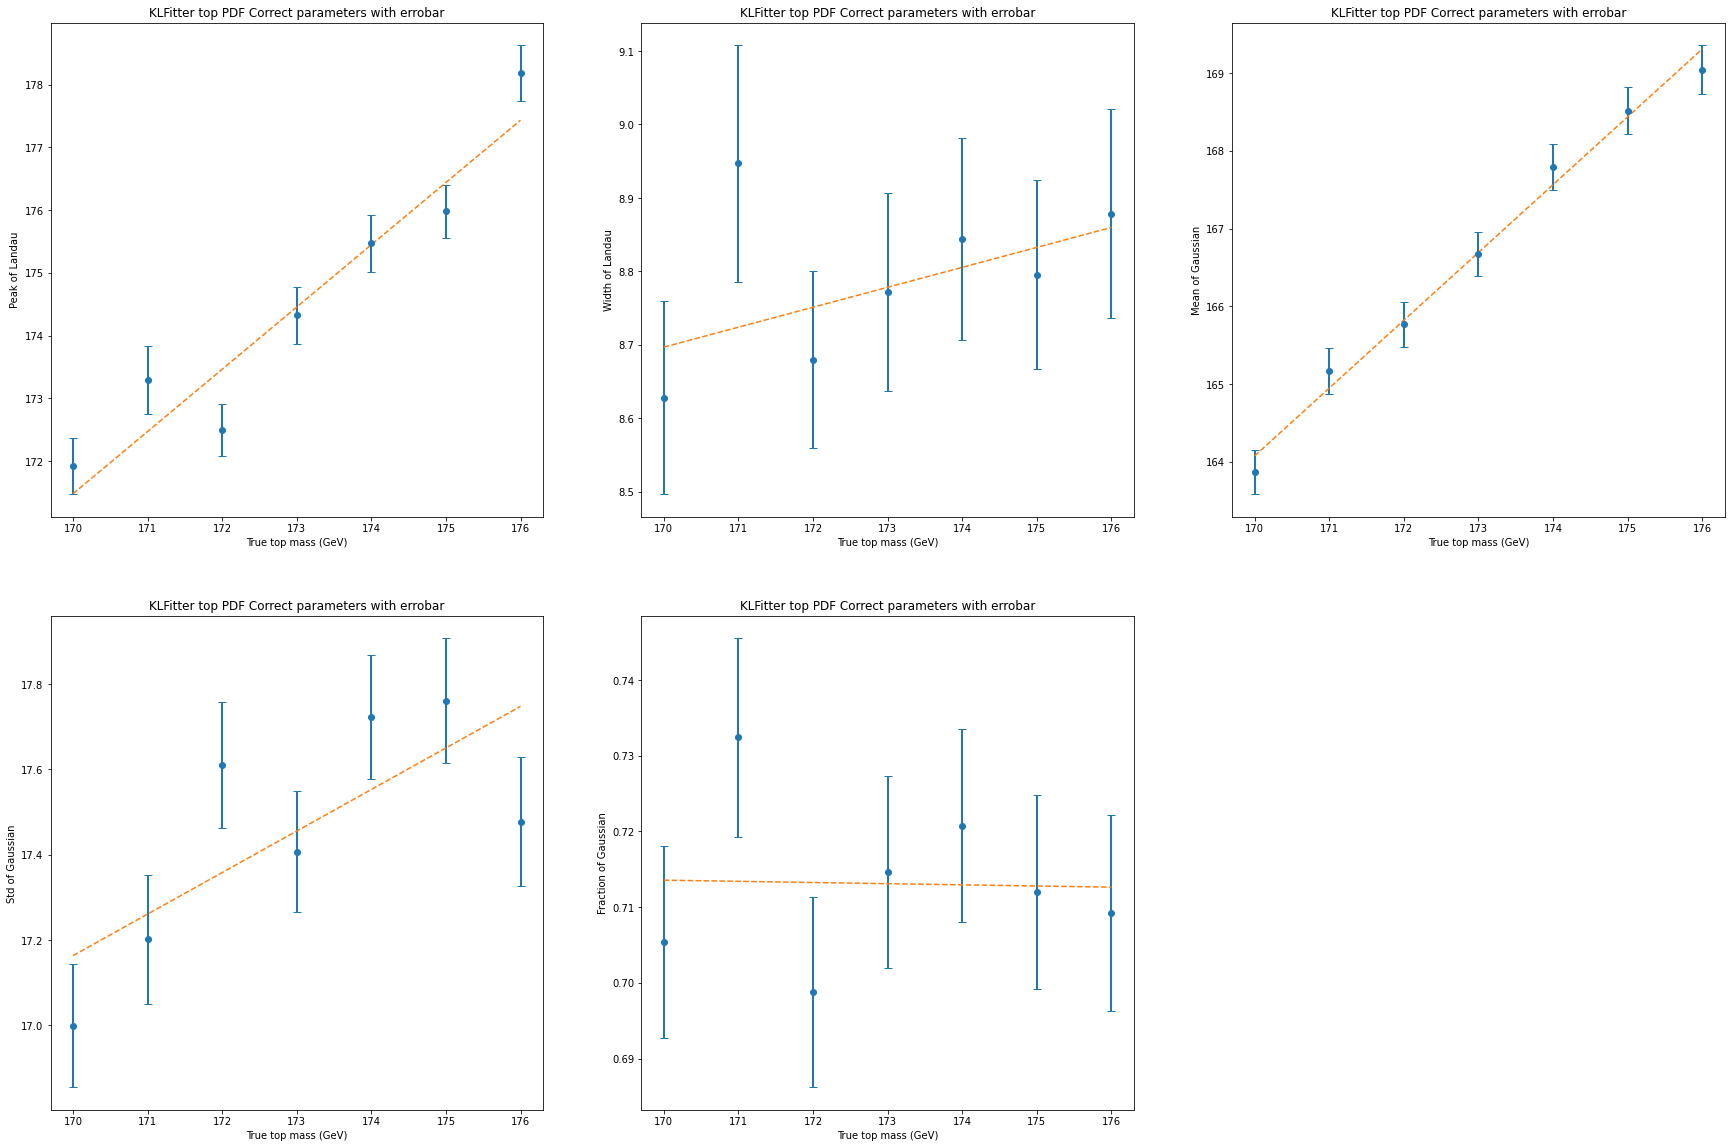

In [27]:
pdf_klf_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'KLFitter top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/KLFitter_param_fit/KLFitter top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


In [28]:
pdf_klf_top_dic

defaultdict(list,
            {(0, 0): array([  1.4365994 , 166.08724759]),
             (0, 1): array([-0.52120701, 28.62712995]),
             (0, 2): array([ -1.8659057 , 149.32886822]),
             (0, 3): array([ 0.69339656, 28.50499321]),
             (0, 4): array([0.03579876, 0.1413001 ]),
             (1, 0): array([  0.20841899, 146.55901768]),
             (1, 1): array([-0.14306603, 22.025466  ]),
             (1, 2): array([  3.05140207, 163.15262301]),
             (1, 3): array([-1.74253878, 19.74861651]),
             (1, 4): array([-0.05968426,  0.18132154]),
             (2, 0): array([  0.99250354, 174.45429572]),
             (2, 1): array([0.02715157, 8.77836686]),
             (2, 2): array([  0.8727547 , 166.69151588]),
             (2, 3): array([ 0.09744603, 17.45554771]),
             (2, 4): array([-1.54190929e-04,  7.13100158e-01])})

In [ ]:
fit_limit = [(0.5, 1.5), (0.5, 1.5), (0.5, 1.5), (0.5, 1.5), (0.5, 1.5)]
for _ in range(100):
    # Fit every class of klfitter
    fit_popt_dic = {i:{} for i in states}
    fit_perr_dic = {i:{} for i in states}

    for state_i in states:
        popt_klf_arr = []
        perr_klf_arr = []

        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)
            tot_event = len(fit_target)
            tol = 0.01
            while True:
                try:
                    start = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
                    minuit = Minuit(fcn, *start)
                    minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 2
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
    pdf_klf_top_dic = defaultdict(list)
    for state_i in states:
        plt.figure(figsize=(30, 20))
        for i in range(5):
            plt.subplot(2, 3, i+1)
            popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
            pdf_klf_top_dic[(state_i, i)] = popt
    print(pdf_klf_top_dic)


In [ ]:
pdf_klf_top_dic

In [ ]:
pdf_spanet_top_dic = {(0, 0): np.array([  0.8076184, 156.3880323]),
             (0, 1): np.array([ 0.15941326, 16.68395458]),
             (0, 2): np.array([-1.68890043e-01,  1.70750363e+02]),
             (0, 3): np.array([-0.07606706, 24.87927635]),
             (0, 4): np.array([0.00290052, 0.63855297]),
             (1, 0): np.array([  3.87929585, 164.11981729]),
             (1, 1): np.array([ 0.04612084, 16.71073477]),
             (1, 2): np.array([1.10886296e-02, 1.67584926e+02]),
             (1, 3): np.array([ 0.13822929, 19.77407   ]),
             (1, 4): np.array([0.00983995, 0.8513105 ]),
             (2, 0): np.array([  0.83916228, 174.90457656]),
             (2, 1): np.array([-0.06522788,  8.66947958]),
             (2, 2): np.array([  0.82425498, 167.48253225]),
             (2, 3): np.array([ 0.12413919, 17.69520343]),
             (2, 4): np.array([0.00296395, 0.73774676])}
fit_limit = [(0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]

In [ ]:
# Fit every class of SPAnet
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    popt_spanet_arr = []
    perr_spanet_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m], state_spanet_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        tol = 0.1
        while True:
            try:
                start = [linear(m, *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
                minuit = Minuit(fcn, *start)
                minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                minuit.tol = tol
                minuit.migrad()
                minuit.minos()
            except: tol *= 2
            else: break
        popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('SPAnet {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/SPAnet_pdf_fit/SPAnet top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

In [ ]:
pdf_spanet_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'SPAnet top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/SPAnet_param_fit/SPAnet top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


In [ ]:
pdf_perfect_top_dic = {(2, 0): [0.8801216063851379, 175.70082664545367],
 (2, 1): [0.007239386181708742, 10.252515714145954],
 (2, 2): [0.9458051496922188, 164.6100205995234],
 (2, 3): [0.15866219434509493, 19.001078593178544],
 (2, 4): [0.0030657407711877343, 0.631158387561709]}

In [ ]:
# Fit every class of perfect
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in [2]:
    popt_perfect_arr = []
    perr_perfect_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_perfect_dic[m][np.logical_and.reduce((cut_perfect_dic[m], likeli_perfect_dic[m], state_perfect_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        tol = 0.1
        while True:
            try:
                start = [linear(m, *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
                minuit = Minuit(fcn, *start)
                minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                minuit.tol = tol
                minuit.migrad()
                minuit.minos()
            except: tol *= 2
            else: break
        popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('perfect {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/perfect_pdf_fit/perfect top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

In [ ]:
pdf_perfect_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_perfect_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'perfect top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/perfect_param_fit/perfect top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


In [ ]:
# Compare the KLFitter template histogram and the pdf
for state_i in states:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {} compare, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/KLFitter_param_fit/KLFitter top {state_labels[state_i]} pdf compare.png', bbox_inches='tight')
    plt.show()

In [ ]:
# Compare the spanet template histogram and the pdf
for state_i in states:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m], state_spanet_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = [linear(m, *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPAnet {} compare, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/SPAnet_param_fit/SPAnet top {state_labels[state_i]} pdf compare.png', bbox_inches='tight')
    plt.show()

In [ ]:
# Compare the prefect template histogram and the pdf
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_true_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_true_dic[m] == 2))]
    hist, _ = np.histogram(target, bins=bins, density=True)
    popt = np.array(fita_true_arr)*(m-173)+fitb_true_arr
    y_template_dense_norm = langau_norm(bins_dense, *popt)
    chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
    plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
    plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('Perfect {}, top mass = {}'.format(state_labels[state_i], m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear(m, *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

def combine_true_pdf_func(x, m):
    popt = np.array(fita_true_arr)*(m-173) + fitb_true_arr
    return langau_norm(x, *popt)*ratio_spanet[state_i]

In [ ]:
fig = plt.figure(figsize=(15,30))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)
for i, m in enumerate(mass):
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                subplot_spec=outer[i], wspace=0.2, hspace=0.4)
    ax = plt.Subplot(fig, inner[:2])
    target = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in states:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins)
        ax.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    ax.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    ax.set_title('klfitter, top mass = {}'.format(m))
    ax.set_xlabel('reco top mass (GeV)')
    ax.set_ylabel('density')
    ax.legend(loc='upper right')
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[2])
    hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins, density=True)
    sigma = np.sqrt(np.histogram(target, bins=bins)[0])/len(fit_target)
    ax.errorbar(bins_mid, hist-combine_klf_pdf_func(bins_mid, m), yerr=sigma, fmt='o', elinewidth=bins_w, capsize=4)
    ax.set_ylabel('density difference')
    ax.set_ylim(-0.001, 0.001)
    fig.add_subplot(ax)
plt.show()

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in states:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('KLFitter pdf compare, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in states:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, likeli_spanet_dic[m], cut_spanet_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPAnet pdf compare, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
def chi2_klf_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_klf_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_spanet_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_spanet_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_true_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_true_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

In [ ]:
m = 173
plt.figure(figsize=(8, 8))
sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_klf_mtop, template_klf_std = minuit.values['m'], minuit.errors['m']

sudo_spanet = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
# n1 = combine_spanet_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='spanet best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_spanet_mtop, template_spanet_std = minuit.values['m'], minuit.errors['m']

# sudo_true = reco_true_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_true_dic[m] == 2))]
# n1 = np.histogram(sudo_true, bins=bins)[0]
# # n1 = combine_true_pdf_func(bins_mid, m)*tot_event*bins_w
# # n1 = np.random.poisson(n1)
# minuit = Minuit(chi2_true_arr_func, m=m)
# minuit.migrad()
# minuit.hesse()
# minuit.minos()
# a, fa, ok = minuit.mnprofile("m")
# plt.plot(a, fa-min(fa))
# plt.scatter(minuit.values['m'], 0, label='true best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
# template_true_mtop, template_true_std = minuit.values['m'], minuit.errors['m']

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
m = 173
plt.figure(figsize=(8, 8))
sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf extracted top mass = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_klf_mtop, template_klf_std = minuit.values['m'], minuit.errors['m']

sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
# n1 = np.histogram(sudo_klf, bins=bins)[0]
n1 = combine_klf_pdf_func(bins_mid, m)*len(sudo_klf)*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf extracted top mass (pdf) = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_klf_mtop, template_klf_std = minuit.values['m'], minuit.errors['m']

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Sudo experiment for KLFitter
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}

for m in tqdm(mass, total=len(mass)):
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(sudo_event, len(bins)-1)
    def minimize_chi2(i):
        chi2_klf_arr_fcn = lambda m: -2*np.sum(n1_arr[i]*np.log(combine_klf_pdf_func(bins_mid, m)*sum(n1_arr[i])*bins_w))
        minuit = Minuit(chi2_klf_arr_fcn, m=173)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        return list(minuit.values), list(minuit.errors)
    with Pool() as pool:
        results = []
        for i in range(sudo_event):
            results.append(pool.apply_async(minimize_chi2, args=((i,))))

        mean, std = [], []
        for result in results:
            res = result.get()
            mean.extend(res[0])
            std.extend(res[1])
        sudo_klf_top_mean_dic[m] = mean
        sudo_klf_top_std_dic[m] = std



In [ ]:
# Sudo experiment for SPAnet
sudo_spanet_top_mean_dic = {}
sudo_spanet_top_std_dic = {}

for m in tqdm(mass, total=len(mass)):
    sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_spanet, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    def minimize_chi2(i):
        chi2_spanet_arr_fcn = lambda m: -2*np.sum(n1_arr[i]*np.log(combine_spanet_pdf_func(bins_mid, m)*sum(n1_arr[i])*bins_w))+sum(n1_arr[i])
        minuit = Minuit(chi2_spanet_arr_fcn, m=173)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        return list(minuit.values), list(minuit.errors)
    with Pool() as pool:
        results = []
        for i in range(sudo_event):
            results.append(pool.apply_async(minimize_chi2, args=((i,))))

        mean, std = [], []
        for result in results:
            res = result.get()
            mean.extend(res[0])
            std.extend(res[1])
        sudo_spanet_top_mean_dic[m] = mean
        sudo_spanet_top_std_dic[m] = std

In [ ]:
np.savez('top_mass_pseudo_experiment/sudo_klf.npz', sudo_klf_top_mean_dic=sudo_klf_top_mean_dic, sudo_klf_top_std_dic=sudo_klf_top_std_dic)
np.savez('top_mass_pseudo_experiment/sudo_spanet.npz', sudo_spanet_top_mean_dic=sudo_spanet_top_mean_dic, sudo_spanet_top_std_dic=sudo_spanet_top_std_dic)


In [ ]:
data = np.load('top_mass_pseudo_experiment/sudo_klf.npz', allow_pickle=True)
sudo_klf_top_mean_dic = data['sudo_klf_top_mean_dic'].item()
sudo_klf_top_std_dic = data['sudo_klf_top_std_dic'].item()

data = np.load('top_mass_pseudo_experiment/sudo_spanet.npz', allow_pickle=True)
sudo_spanet_top_mean_dic = data['sudo_spanet_top_mean_dic'].item()
sudo_spanet_top_std_dic = data['sudo_spanet_top_std_dic'].item()


In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.8, m+0.5, 0.02)
    plt.hist(sudo_klf_top_mean_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_klf_top_mean_dic[m]):.2f}')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.2 best fit top mass')
    plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(0.1, 0.11, 0.0001)
    plt.hist(sudo_klf_top_std_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_klf_top_std_dic[m]):.2f}')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Extracted top mass std')
    plt.ylabel('Density/0.0001 extracted top mass std')
    plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter true and prediction comparison for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias for different true top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

klf_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_klf_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_klf_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_klf_top_func(extracted_top): return (np.array(extracted_top) - klf_popt[1])/klf_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(predicted_klf_top_func(sudo_klf_top_mean_dic[m]), bins=bins_top, density=True, histtype='step', label=f'mean = {predicted_klf_top_func(np.mean(sudo_klf_top_mean_dic[m])):.2f}')
    plt.title('KLFitter biased fixed, true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
    plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_klf_top_func(sudo_klf_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_klf_top_func(sudo_klf_top_mean_dic[m])-m) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

plt.figure(figsize = (6, 6))
klf_top_pull = [(predicted_klf_top_func(sudo_klf_top_mean_dic[m])-m)/sudo_klf_top_std_dic[m] for m in mass]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
klf_pull_mean, klf_pull_mean_std, klf_pull_sigma, klf_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('KLFitter top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.8, m+0.5, 0.02)
    plt.hist(sudo_spanet_top_mean_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_spanet_top_mean_dic[m]):.3f}')
    plt.title('SPAnet true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
    plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(0.085, 0.09, 0.0001)
    plt.hist(sudo_spanet_top_std_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_spanet_top_std_dic[m]):.3f}')
    plt.title('SPAnet true top mass = {}'.format(m))
    plt.xlabel('best fit std')
    plt.ylabel('density/0.0001 best fit std')
    plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet true and prediction comparison for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

spanet_top_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_spanet_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_spanet_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_spanet_top_func(extracted_top): return (np.array(extracted_top) - spanet_top_popt[1])/spanet_top_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m]), bins=np.arange(m-0.5, m+0.5, 0.02), density=True, histtype='step', label=f'mean = {predicted_spanet_top_func(np.mean(sudo_spanet_top_mean_dic[m])):.3f}')
    plt.title('SPAnet biased fixed, true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
    plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m]))-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

plt.figure(figsize = (6, 6))
spanet_top_pull = [(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m])-m)/sudo_spanet_top_std_dic[m] for m in mass]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
spanet_pull_mean, spanet_pull_mean_std, spanet_pull_sigma, spanet_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('SPAnet top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [ ]:
m = 173
plt.figure(figsize=(8, 8))
sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
template_klf_mtop, template_klf_std = predicted_klf_top_func(minuit.values['m']), minuit.errors['m']
plt.plot(predicted_klf_top_func(a), fa-min(fa))
plt.scatter(template_klf_mtop, 0, label='klf best fit = {:.3f}({:.3f})'.format(template_klf_mtop, template_klf_std))

sudo_spanet = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
# n1 = combine_spanet_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
template_spanet_mtop, template_spanet_std = predicted_spanet_top_func(minuit.values['m']), minuit.errors['m']
plt.plot(predicted_spanet_top_func(a), fa-min(fa))
plt.scatter(template_spanet_mtop, 0, label='spanet best fit = {:.3f}({:.3f})'.format(template_spanet_mtop, template_spanet_std))

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('{:.2f}({:.2f})'.format((template_klf_mtop-klf_popt[1])/klf_popt[0], template_klf_std))
print('{:.3f}({:.3f})'.format(klf_pull_mean, klf_pull_mean_std))
print('{:.4f}({:.4f})'.format(klf_pull_sigma, klf_pull_sigma_std))
print('{:.3f}({:.3f})'.format((template_spanet_mtop-spanet_popt[1])/spanet_popt[0], template_spanet_std))
print('{:.4f}({:.4f})'.format(spanet_pull_mean, spanet_pull_mean_std))
print('{:.4f}({:.4f})'.format(spanet_pull_sigma, spanet_pull_sigma_std))